## 파이토치 모델 훈련
- 튜토리얼 영상의 17분 10초

In [1]:
## Import
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms


C:\Users\user\miniconda3\envs\mmcv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\miniconda3\envs\mmcv\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\user\miniconda3\envs\mmcv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root = "./data", train = True,
                                       download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 1,
                                         shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                      download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = 1,
                                        shuffle = True, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'froh', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


- 데이터 로더에 있는 결과를 확인하는 방법

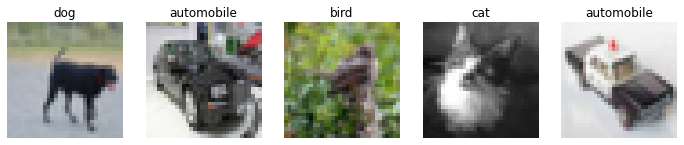

In [3]:
## 시각화 함수 만들기
## 이미지 데이터 시각화
import numpy as np

label_seq = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

plt.figure(figsize = (12, 12))

for i in range(5):
    index = np.random.randint(0, 50000)
    
    img = trainset.data[index,:,:,:]
    label_index = trainset.targets[index]
    label = label_seq[label_index]
    plt.subplot(1,5,i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(label)

plt.show()


- 이제 모델을 훈련시킬 것이다.
- 어디서 본것 같다면, 그건 LeNet의 변형한 모델이라 그렇습니다.
- 이 모델은 앞서 언급한것 처럼 3색(RGB) 이미지를 훈련하는데 적합한 모델로 변형한 모습입니다.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

- 마지막으로 Loss 함수와 옵티마이저를 설정

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

- 로스 함수는 모델이 이상적인 결과물을 예측하기 위한 추론 방법이다.
- 전형적으로 분류 모델들은 CrossEntropyLoss 함수를 사용한다.

- 옵티마이저는 학습 드라이버이다. 여기에서 보다 간단한 최적화 알고리즘 중 하나인 확률적 경사 하강법(SGD(stochastic gradient descent))을 구현하는 최적화 프로그램을 만들었습니다.

- net.parameters()를 통해서 이 알고리즘에 기본적인 파라미터들은 학습률(lr)과 모멘텀의 모든 학습 weight들을 모을 수 있다.

- 마침내, 훈련 루프를 통해서 결합된다.
- 실행하는 데 몇 분 정도 걸릴 수 있으므로 이 셀을 실행하세요.

In [6]:
## 훈련을 2 epoch만 수행
## 즉, 훈련을 2번한다.
for epoch in range(2):
    
    running_loss = 0.0
    
    ## 이 내부 루프에서는 변형된 이미지와 고쳐진 라벨을 
    ## 하나에 배치에 묶어 훈련 데이터 셋을 반복적으로 학습한다.
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        
        ## Zeroing 그레디언트의 중요한 단계이다.
        ## 그레디언트는 각 배치마다 누적된다.
        ## 만약 모든 배치를 초기화 하지 않는다면,
        ## 그레디언트는 계속해서 축적될 것이고,
        ## 잘 못된 그레디언트 값을 제공받아
        ## 학습이 불가능하게 된다.
        optimizer.zero_grad()
        
        ## 각 배치마다 모델이 예측한다.
        outputs = net(inputs)
        
        ## 실제 값(labels)과 예측 값(outputs) 사이의 차이를
        ## loss값으로 계산한다.
        loss = criterion(outputs, labels)
        
        ## 우리는 학습으로 backward를 통해 그레디언트를 계산한다.
        loss.backward()
        
        ## 옵티마이저는 한번 학습에 step을 수행합니다.
        ## loss 값을 감소 시키는 방향에 있는 학습 가중치를 불러와
        ## backward로 부터 그레디언트를 사용합니다.
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % 
                  (epoch + 1, i + 1, running_loss / 2000))
            
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.245
[1,  4000] loss: 2.082
[1,  6000] loss: 1.907
[1,  8000] loss: 1.830
[1, 10000] loss: 1.808
[1, 12000] loss: 1.728
[1, 14000] loss: 1.720
[1, 16000] loss: 1.720
[1, 18000] loss: 1.666
[1, 20000] loss: 1.648
[1, 22000] loss: 1.647
[1, 24000] loss: 1.610
[1, 26000] loss: 1.607
[1, 28000] loss: 1.596
[1, 30000] loss: 1.596
[1, 32000] loss: 1.594
[1, 34000] loss: 1.595
[1, 36000] loss: 1.572
[1, 38000] loss: 1.552
[1, 40000] loss: 1.606
[1, 42000] loss: 1.551
[1, 44000] loss: 1.575
[1, 46000] loss: 1.552
[1, 48000] loss: 1.562
[1, 50000] loss: 1.562
[2,  2000] loss: 1.524
[2,  4000] loss: 1.518
[2,  6000] loss: 1.500
[2,  8000] loss: 1.518
[2, 10000] loss: 1.509
[2, 12000] loss: 1.466
[2, 14000] loss: 1.508
[2, 16000] loss: 1.556
[2, 18000] loss: 1.542
[2, 20000] loss: 1.502
[2, 22000] loss: 1.531
[2, 24000] loss: 1.512
[2, 26000] loss: 1.528
[2, 28000] loss: 1.519
[2, 30000] loss: 1.539
[2, 32000] loss: 1.553
[2, 34000] loss: 1.521
[2, 36000] loss: 1.530
[2, 38000] 

- 손실은 단조롭게 내림차순이며, 이는 우리 모델이 훈련 데이터 세트에 대한 성능을 계속 개선하고 있음을 나타냅니다.
- 마지막 단계로 우리는 모델이 단순히 데이터 세트를 "암기"하는 것이 아니라 실제로 일반 학습을 수행하는지 확인해야 합니다.
- 이를 과적합이라고 하며 일반적으로 데이터 세트가 너무 작거나(일반 학습에 대한 예제가 충분하지 않음) 모델에 데이터 세트를 올바르게 모델링하는 데 필요한 것보다 더 많은 학습 매개변수가 있음을 나타냅니다.
- 이것이 데이터 세트가 훈련 및 테스트 데이터 셋으로 분할되는 이유입니다.- 모델의 일반화를 테스트하기 위해 훈련하지 않은 데이터(처음보는 데이터)에 대한 예측을 수행하도록 요청합니다.

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %


- 모델의 정확도가 대략 50%임을 알 수 있습니다.
- 이것은 모델에서 일부 일반적인 학습이 발생했음을 보여줍니다.